#### The goal of this notebook is to find the optimal split ratio for training and validation

In [1]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms
from ImageDataset import *
from unet import *
from loss import *
import matplotlib.pyplot as plt
import os
import zipfile
from helper import *

In [2]:
#Unzip data.
#It is useful when we want to run the code on Google Colab.
data_path = 'data.zip'

with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall()


In [2]:
TRAIN_IMAGES = 'data/training/images/'
GROUNDTRUTH = 'data/training/groundtruth/'
PREDICTIONS_PATH= 'predictions/'
FOREGROUND_TRESHOLD = 0.25
BATCH_SIZE = 10
EPOCHS = 100
LR = 1e-3
SEED = 4
WEIGHT_DECAY = 1e-3
WORKERS = 2

In [3]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
pin_memory = device == 'cuda'

Device: cpu


In [5]:
# Define image and mask transformations using torchvision.transforms.Compose.
# For both image and mask, convert the input to a PyTorch tensor using transforms.ToTensor().
image_transform = transforms.Compose([
    transforms.ToTensor(),
])
mask_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [6]:
# Create an instance of the ImagesDataset class with specified parameters.
dataset = ImagesDataset(
    img_dir=TRAIN_IMAGES,
    gt_dir=GROUNDTRUTH,
    image_transform=image_transform,
    mask_transform=mask_transform,
)

In [7]:
# Display the number of images in the dataset.
len(dataset)

100

In [9]:
image, mask = dataset[0]
print('Image size:', image.shape)
print('Mask size:', mask.shape)

Image size: torch.Size([3, 400, 400])
Mask size: torch.Size([1, 400, 400])


In [10]:
#Create datasets according to the split ratios
ratios= [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
datasets = [split_data(dataset, ratio, SEED) for ratio in ratios]

In [12]:
#Create train loaders
train_loaders= [DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS, pin_memory=pin_memory) for train_dataset, test_dataset in datasets]

In [13]:
#Create test loaders for local evaluation
local_test_loaders= [DataLoader(test_dataset, num_workers=WORKERS, pin_memory=pin_memory) for train_dataset, test_dataset in datasets]

In [14]:
#Display the length of the first testset (local)
len(local_test_loaders[0].dataset)

10

In [15]:
#Display the length of the first trainset
len(train_loaders[0].dataset)

90

In [16]:
#Create models
models= [UNet().to(device) for i in range(len(datasets))]

In [17]:
#Create loss functions and optimizers
criterion = DiceLoss()
optimizers = [Adam(models[i].parameters(), lr=LR, weight_decay=WEIGHT_DECAY) for i in range(len(datasets))]

In [ ]:
#Create learing rate schedulers
lr_schds= [ReduceLROnPlateau(optimizers[i], mode='min', patience=3, verbose=True) for i in range(len(datasets))]

In [ ]:
#Cross validation

models_loss= list()
modeles_metrics= list()
for i in range(len(datasets)):
    print(f"Training model {i}")
    losses = train(models[i], train_loaders[i], criterion, optimizers[i], device,EPOCHS, lr_schds[i])
    models_loss.append(losses)
    print(f"Predicting model {i}")
    metric= predict(models[i], local_test_loaders[i], device,PREDICTIONS_PATH, FOREGROUND_TRESHOLD)
    modeles_metrics.append(metric)

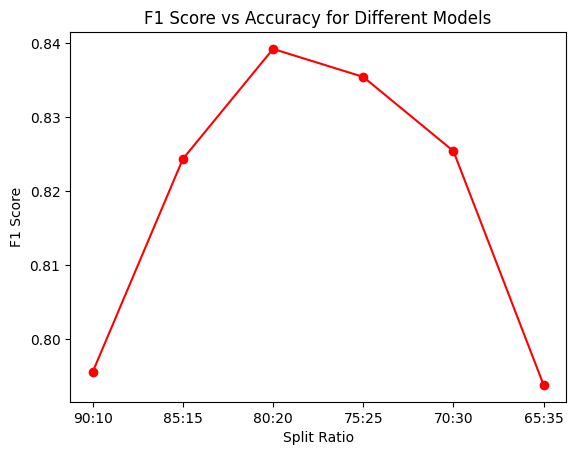

In [31]:
#Plot the F1-Score curves for different split ratios

f1_scores = [item[0] for item in modeles_metrics]
#accuracies = [item[1] for item in modeles_metrics]
m=['90:10', '85:15', '80:20', '75:25', '70:30', '65:35']

plt.plot(m, f1_scores, color='red', linestyle='-', marker= 'o')
plt.title('F1 Score vs Split Ratio')
plt.xlabel('Split Ratio')
plt.ylabel('F1 Score')
plt.show()

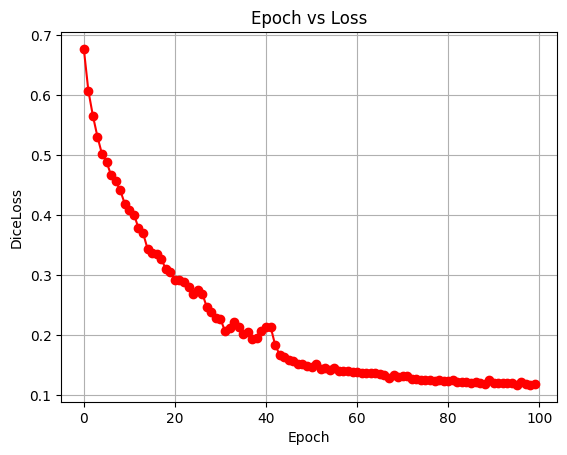

In [40]:
#Plot the loss curves for different epochs

chosen_model= models_loss[2]
epochs = [item[0] for item in chosen_model]
losses = [item[1] for item in chosen_model]

# Plotting
plt.plot(epochs, losses, color='red', marker='o', linestyle='-')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('DiceLoss')
plt.grid(True)
plt.show()
